In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split


In [43]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [44]:
base_skin_dir = os.path.join('C:/','Users','vivek348','Pictures','DSP_Project','Image','input')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [45]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [46]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:/Users\vivek348\Pictures\DSP_Project\Image\i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:/Users\vivek348\Pictures\DSP_Project\Image\i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:/Users\vivek348\Pictures\DSP_Project\Image\i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:/Users\vivek348\Pictures\DSP_Project\Image\i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:/Users\vivek348\Pictures\DSP_Project\Image\i...,Benign keratosis-like lesions,2


In [47]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [48]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [49]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [50]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


In [51]:
skin_df['path']=skin_df['path'].astype(object)

<AxesSubplot:>

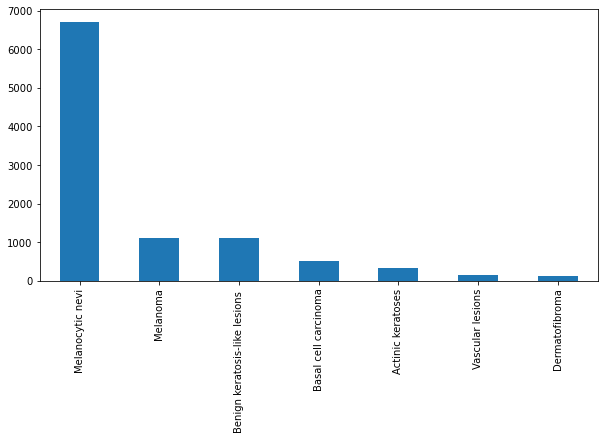

In [52]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [53]:
skin_df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [54]:
# Separate majority and minority classes
from sklearn.utils import resample
skin_df_majority = skin_df[skin_df['dx']=='nv']
skin_df_minority = skin_df[skin_df['dx']!='nv']
 
# Downsample majority class
skin_df_majority_downsampled = resample(skin_df_majority, 
                                 replace=False,    
                                 n_samples=1800)
#Upsample minority class
skin_df_minority_upsampled = resample(skin_df_minority, 
                                 replace=True,     
                                 n_samples=5000)
# Combine minority class with downsampled majority class
skin_df_up_down_sampled = pd.concat([skin_df_majority_downsampled, skin_df_minority_upsampled])
skin_df_up_down_sampled['dx'].value_counts()

nv       1800
bkl      1661
mel      1654
bcc       770
akiec     518
vasc      217
df        180
Name: dx, dtype: int64

In [55]:
skin_df=skin_df_up_down_sampled

<AxesSubplot:>

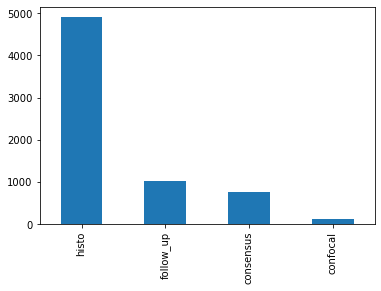

In [56]:
skin_df['dx_type'].value_counts().plot(kind='bar')

<AxesSubplot:>

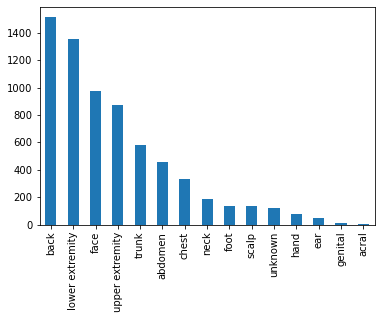

In [57]:
skin_df['localization'].value_counts().plot(kind='bar')

<AxesSubplot:>

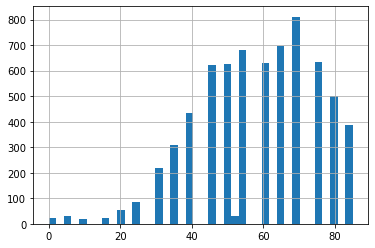

In [58]:
skin_df['age'].hist(bins=40)

<AxesSubplot:>

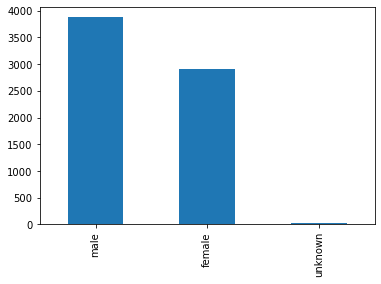

In [59]:
skin_df['sex'].value_counts().plot(kind='bar')

C:\Users\vivek348\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='age', ylabel='cell_type_idx'>

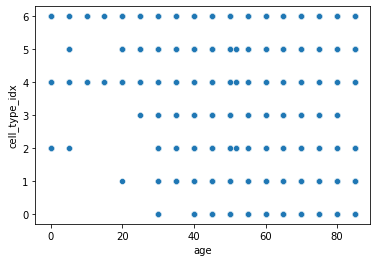

In [60]:
sns.scatterplot('age','cell_type_idx',data=skin_df)

C:\Users\vivek348\Anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\vivek348\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


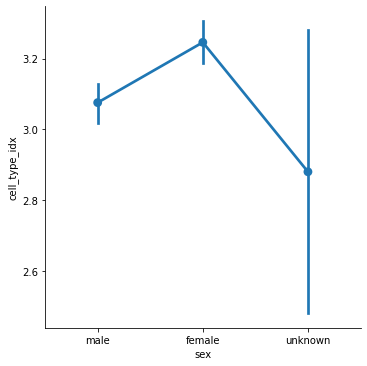

In [61]:
sns.factorplot('sex','cell_type_idx',data=skin_df)

In [62]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [63]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
8666,HAM_0005631,ISIC_0025492,nv,histo,55.0,male,back,C:/Users\vivek348\Pictures\DSP_Project\Image\i...,Melanocytic nevi,4,"[[[196, 150, 133], [204, 150, 133], [204, 148,..."
8933,HAM_0006596,ISIC_0027005,nv,histo,35.0,male,back,C:/Users\vivek348\Pictures\DSP_Project\Image\i...,Melanocytic nevi,4,"[[[128, 110, 126], [130, 111, 129], [131, 112,..."
8343,HAM_0002628,ISIC_0031204,nv,histo,50.0,male,lower extremity,C:/Users\vivek348\Pictures\DSP_Project\Image\i...,Melanocytic nevi,4,"[[[184, 139, 143], [183, 138, 141], [186, 138,..."
8703,HAM_0004942,ISIC_0028202,nv,histo,75.0,male,back,C:/Users\vivek348\Pictures\DSP_Project\Image\i...,Melanocytic nevi,4,"[[[161, 136, 122], [163, 142, 131], [162, 142,..."
6545,HAM_0002020,ISIC_0032301,nv,follow_up,50.0,male,trunk,C:/Users\vivek348\Pictures\DSP_Project\Image\i...,Melanocytic nevi,4,"[[[200, 90, 113], [206, 97, 117], [209, 98, 11..."


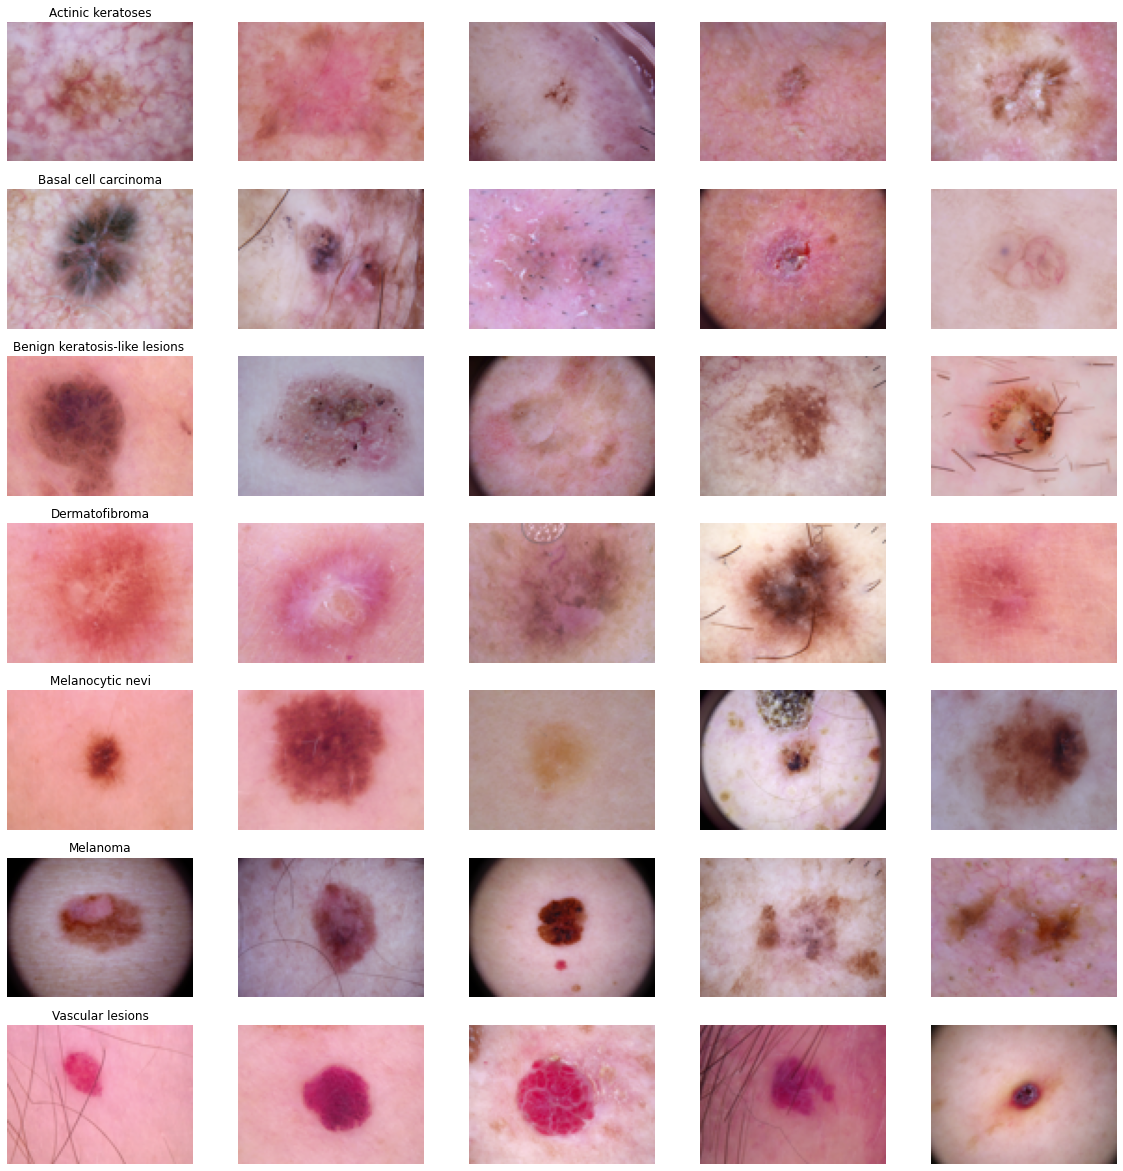

In [64]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [65]:
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    6800
Name: image, dtype: int64

In [66]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [67]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

In [68]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [69]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [70]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 2)

In [71]:
x_train.shape[0]

4352

In [72]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [73]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
#model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
#model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(32, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.10))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 75, 100, 32)       896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 25, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 18, 25, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 18, 25, 32)       

In [74]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

C:\Users\vivek348\Anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [75]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [76]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [77]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [78]:
# Fit the model
epochs = 50 
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                               , callbacks=[learning_rate_reduction])
#history = model.fit(x_train,y_train, batch_size=batch_size,epochs = epochs, validation_data = (x_validate,y_validate),
 #                            verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
  #                          , callbacks=[learning_rate_reduction])

C:\Users\vivek348\Anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
435/435 [==============================] - 32s 72ms/step - loss: 1.4697 - accuracy: 0.4058 - val_loss: 1.3445 - val_accuracy: 0.4825
Epoch 2/50
435/435 [==============================] - 32s 74ms/step - loss: 1.2937 - accuracy: 0.4982 - val_loss: 1.2956 - val_accuracy: 0.5055
Epoch 3/50
435/435 [==============================] - 32s 73ms/step - loss: 1.2174 - accuracy: 0.5302 - val_loss: 1.1767 - val_accuracy: 0.5708
Epoch 4/50
435/435 [==============================] - 32s 74ms/step - loss: 1.1438 - accuracy: 0.5636 - val_loss: 1.0556 - val_accuracy: 0.6241
Epoch 5/50
435/435 [==============================] - 32s 73ms/step - loss: 1.0783 - accuracy: 0.5912 - val_loss: 1.0369 - val_accuracy: 0.6085
Epoch 6/50
435/435 [==============================] - 33s 75ms/step - loss: 1.0343 - accuracy: 0.5997 - val_loss: 0.9899 - val_accuracy: 0.6388
Epoch 7/50
435/435 [==============================] - 32s 74ms/step - loss: 0.9772 - accuracy: 0.6188 - val_loss: 0.9398 - val_accuracy:

Epoch 28/50
435/435 [==============================] - 33s 75ms/step - loss: 0.5653 - accuracy: 0.7814 - val_loss: 0.6914 - val_accuracy: 0.7564
Epoch 29/50
435/435 [==============================] - 33s 76ms/step - loss: 0.5495 - accuracy: 0.7953 - val_loss: 0.8748 - val_accuracy: 0.6857
Epoch 30/50
435/435 [==============================] - 33s 76ms/step - loss: 0.5485 - accuracy: 0.7906 - val_loss: 0.6681 - val_accuracy: 0.7831
Epoch 31/50
435/435 [==============================] - 33s 75ms/step - loss: 0.5059 - accuracy: 0.8047 - val_loss: 0.7360 - val_accuracy: 0.7574
Epoch 32/50
435/435 [==============================] - 33s 76ms/step - loss: 0.5114 - accuracy: 0.7989 - val_loss: 0.6482 - val_accuracy: 0.7822
Epoch 33/50
435/435 [==============================] - 33s 76ms/step - loss: 0.4898 - accuracy: 0.8125 - val_loss: 0.7236 - val_accuracy: 0.7619
Epoch 34/50
435/435 [==============================] - 33s 76ms/step - loss: 0.4726 - accuracy: 0.8204 - val_loss: 0.7852 - val_ac

In [79]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

34/34 [==============================] - 1s 43ms/step - loss: 0.6583 - accuracy: 0.7932
Validation: accuracy = 0.793199  ;  loss_v = 0.658298
Test: accuracy = 0.794853  ;  loss = 0.702368


<ipython-input-43-6b7ad8b7a74f>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
<ipython-input-43-6b7ad8b7a74f>:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)


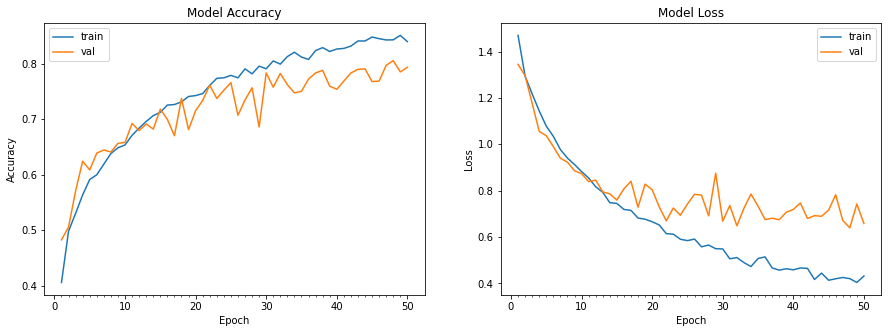

In [80]:
plot_model_history(history)

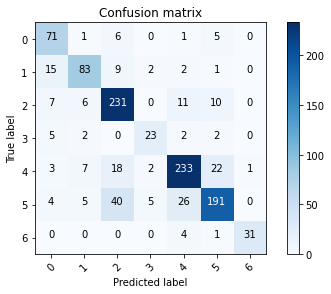

In [81]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 


Text(0, 0.5, 'Fraction classified incorrectly')

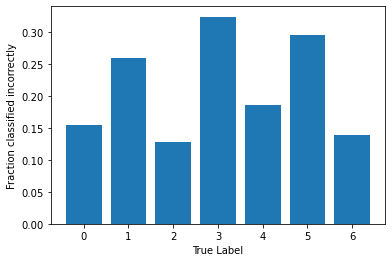

In [82]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')